In [131]:
import itertools


def generate_genotype_matrix(n_snps: int):
    """
    Generate a binary genotypes matrix given a number of total snps to model the genotypes of.
    
    Argument(s):
    n_snps: number of total snps to model
    """
    
    #MAKE SURE THERE ARE ENOUGH SNPS TO GENERATE A GENOTYPE MATRIX
    
    #if there are less than 2 snps, only 1 conformation is possible
    if n_snps<2:
        #return the only possible conformation of no snps
        return 0
    
    
    #GENERATE PHENOTYPES AND HAPLOTYPES
    
    #number of phenotypes assuming 2 possible conformations for each snp
    n_phenotypes = 2**n_snps

    #all possible haplotype pairs
    haplotypes = [list(p) for p in itertools.product(range(2), repeat=n_snps)]
    #all possible combinations of phenotypes
    expanded_grid = [(x, y) for x in range(n_phenotypes) for y in range(n_phenotypes)]
    
    
    #GENERATE GENOTYPES

    #initiate list to store genotypes
    genotypes = []
    #for each possible combination of (0 or 1)
    for indices in expanded_grid:
        #get associated haplotypes (binary)
        haplotype_n = [haplotypes[i] for i in list(indices)]
        #sum haplotypes to get genotype (0, 1, 2)
        genotype_n = tuple(map(sum, zip(*haplotype_n)))
        #append to master list
        genotypes.append(genotype_n)
    #make set of genotypes into strings for use as labels
    genotypes = [('%snp'*len(x)%x).strip() for x in genotypes]

    #all unique genotypes
    unique_genotypes = [p for p in itertools.product(range(3), repeat=n_snps)]
    unique_genotypes = [('%snp'*len(x)%x).strip() for x in unique_genotypes]

    
    #GENERATE GENOTYPE MATRIX
    
    #initiate genotype matrix with all 0s
    genotype_matrix = np.zeros((len(unique_genotypes), n_phenotypes**2))
    #for each unique genotype
    for i in range(len(unique_genotypes)):
        #find all locations within list of genotypes that corresponds to this genotype
        locations = [j for j,d in enumerate(genotypes) if d==unique_genotypes[i]]
        #impute with 1 if genotype label matches
        genotype_matrix[i,locations] = 1

        
    #OUTPUT
    
    #return imputed genotype matrix
    return genotype_matrix

In [132]:
import itertools


def generate_haplotype_probabilities(haplotypes_frequency: object,
                                     fractional_frequency: object):
    """
    Generate haplotype probabilities based on fractional frequencies.
    
    Argument(s):
    haplotypes_frequency: matrix with rows as haplotypes and columns as snps
    fractional_frequency: list with elements as fractional frequencies of each haplotype
    """

    #GENERATE LABELS
    
    #number of haplotypes
    n_haplotypes = haplotypes_frequency.shape[1]
    #number of snps
    n_snps = haplotypes_frequency.shape[0]
    #number of possible binary combinations of haplotype pairs
    n_haplotype_pairs = 2**n_haplotypes

    #get labels as all possible haplotype configurations
    labels = [list(p) for p in itertools.product(range(2), repeat=n_haplotypes)]
    
    
    #GENERATE PROBABILITIES
    
    #initiate probabilties list
    probabilities = [0]*n_haplotype_pairs
    #initiate mapped probabilities dictionary
    mapped_probability = {}

    #for each haplotype pair
    for i in range(n_haplotype_pairs):
        #initiate probability map with haplotype labels as indexes
        mapped_probability[str(labels[i])] = 0

    #for each snp
    for i in range(n_snps):
        #initiate blank label
        line = [0]*n_haplotypes
        #for each haplotype
        for j in range(n_haplotypes):
            #if this is the correct haplotype
            if haplotypes_frequency.iloc[i, j] != 0:
                #indicate this label is present for this snp
                line[j] = 1
        #the haplotype probability is the cummulative sum of the fractional frequency from all haplotypes associated with this snp
        mapped_probability[str(line)] = mapped_probability[str(line)] + fractional_frequency[i]

    #for each haplotype pair
    for i in range(n_haplotype_pairs):
        #record haplotype probabilities to probabilities vector
        probabilities[i] = mapped_probability[str(labels[i])]
    
    
    #OUTPUT
    
    #return probabilities vector
    return probabilities


In [133]:
import math


def generate_genotype_probabilities(genotypes: object,
                                    probabilities: list):
    """
    Generate genotype probabilities from genotypes and haplotype probabilities.
    
    Argument(s):
    genotypes: binary matrix with rows as unique genotypes and columns as all possible genotypes
    probabilities: list with elements as probabilities of each haplotype pair
    """
    
    #COUNT POSSIBLE GENOTYPE
    
    #number of unique genotypes
    n_unique_genotypes = genotypes.shape[0]
    #total number of possible genotypes
    n_total_genotypes = genotypes.shape[1]
    #initiate output list to store genotype probabilities
    genotype_probabilities = [0]*n_unique_genotypes

    
    #CALCULATE GENOTYPES PROBABILITIES
        
    #for each possible genotype
    for i in range(n_total_genotypes):
        #get reference indicating which unique genotype this genotype matches
        reference = genotypes[:, i]
        #probability of this genotype
        probability_n = probabilities[i]

        #initiate loop variable
        j = 0
        #while j is in the neighborhood of the snp
        while j < math.floor(n_unique_genotypes/4)*4:
            #generate initial probabilities for the snp as well as its neighbor
            v0_initial = reference[j] * probability_n
            v1_initial = reference[j+2] * probability_n
            #add reference status to probability
            v0 = reference[j] + v0_initial
            v1 = reference[j+2] + v1_initial
            #input into genotype probabilities vector
            genotype_probabilities[j] = v0
            genotype_probabilities[j+2] = v1
            #stride of 2 to bypass neighbor with effect already generated
            j = j+4
        #for the last genotype with no weighbor
        while j < n_unique_genotypes:
            #probability is equal to neighborhood effect from past genotype along with calculated standard probability
            genotype_probabilities[j] = genotype_probabilities[j] + reference[j]*probabilities[i]
            j = j+1

            
    #OUTPUT
    
    #return vector of probabilities for each genotype
    return genotype_probabilities


In [134]:
import numpy as np


def compute_snp_probabilities(snp: str,
                              causal_variants: list,
                              haplotypes_data: list):
    """
    Compute genotype conditional probabilities for each SNP.
    
    Argument(s):
    snp: the name of the snp
    causal_variants: a list of all causal variant names
    haplotypes_data: matrix with rows as haplotypes and columns as snps, with a final column as fractional frequencies of each haplotype
    """
    
    #GENERATE GENOTYPE MATRICES
    
    #generate all possible genotype configurations matrix
    geno_matrix_2snps = generate_genotype_matrix(2)
    geno_matrix_3snps = generate_genotype_matrix(3)
    geno_matrix_4snps = generate_genotype_matrix(4)
    geno_matrix_5snps = generate_genotype_matrix(5)
    geno_matrix_6snps = generate_genotype_matrix(6)

    #generate all possible combinations of snp alleles given the number of snps
    geno_2SNP = [list(p) for p in itertools.product(range(3), repeat=2)]
    geno_3SNP = [list(p) for p in itertools.product(range(3), repeat=3)]
    geno_4SNP = [list(p) for p in itertools.product(range(3), repeat=4)]
    geno_5SNP = [list(p) for p in itertools.product(range(3), repeat=5)]
    geno_6SNP = [list(p) for p in itertools.product(range(3), repeat=6)]

    #find all indices where the first snp is a specific allele
    which_X0_2SNP = [index for index, num_list in enumerate(geno_2SNP) if num_list[0] == 0]
    which_X1_2SNP = [index for index, num_list in enumerate(geno_2SNP) if num_list[0] == 1]
    which_X2_2SNP = [index for index, num_list in enumerate(geno_2SNP) if num_list[0] == 2]

    which_X0_3SNP = [index for index, num_list in enumerate(geno_3SNP) if num_list[0] == 0]
    which_X1_3SNP = [index for index, num_list in enumerate(geno_3SNP) if num_list[0] == 1]
    which_X2_3SNP = [index for index, num_list in enumerate(geno_3SNP) if num_list[0] == 2]

    which_X0_4SNP = [index for index, num_list in enumerate(geno_4SNP) if num_list[0] == 0]
    which_X1_4SNP = [index for index, num_list in enumerate(geno_4SNP) if num_list[0] == 1]
    which_X2_4SNP = [index for index, num_list in enumerate(geno_4SNP) if num_list[0] == 2]

    which_X0_5SNP = [index for index, num_list in enumerate(geno_5SNP) if num_list[0] == 0]
    which_X1_5SNP = [index for index, num_list in enumerate(geno_5SNP) if num_list[0] == 1]
    which_X2_5SNP = [index for index, num_list in enumerate(geno_5SNP) if num_list[0] == 2]

    which_X0_6SNP = [index for index, num_list in enumerate(geno_6SNP) if num_list[0] == 0]
    which_X1_6SNP = [index for index, num_list in enumerate(geno_6SNP) if num_list[0] == 1]
    which_X2_6SNP = [index for index, num_list in enumerate(geno_6SNP) if num_list[0] == 2]
    

    #FIND CONTRIBUTING SNPS
    
    #if the snp is a causal variant
    if snp in causal_variants:
        #the list of contributing snps are all causal variants
        snp_list = causal_variants
    #if the snp is not a causal variant
    else:
        #the list of contributing snps is this snp along with all causal variants
        snp_list = [snp]+causal_variants
        
    #number of snps contributing to this snps effect
    n_snps = len(snp_list)
    
    #the frequency matrix is the haplotype frequency list for all contributing snps
    haplotypes_frequency = haplotypes_data[snp_list].sub(1)
    #the probability vector is the probability of all haplotypes
    fractional_frequency = haplotypes_data['probability']
    
    #calculate haplotype probabilities
    haplotypes_probability = np.array(generate_haplotype_probabilities(haplotypes_frequency,fractional_frequency))
    
    
    #GENERATE CONDITIONAL PROBABILITIES

    #if there is only 1 contributing snp
    if n_snps == 1:
        #if snp in causal_variants:
        #the effect at this snp follows the equasion a^2+2ab+b^2
        function_output = [[haplotypes_probability[0]**2, 0, 0],
                           [0, 2*haplotypes_probability[0]*haplotypes_probability[1], 0],
                           [0, 0, haplotypes_probability[1]**2]]
        # else: #delete_me???
        # #the effect at this snp follows the equasion a^2+2ab+b^2
        #     function_output = [[haplotypes_probability[1]**2, 0, 0],
        #                        [haplotypes_probability[1]**2, 0, 0],
        #                        [haplotypes_probability[1]**2, 0, 0]]

    #if there are 2 contributing snps
    elif n_snps == 2:
        
        #outer product of haplotype probabilities vector to get probabilities of all paired haplotypes
        vector_input = [x for xs in np.outer(haplotypes_probability, haplotypes_probability.T).tolist() for x in xs]
        #generate genotype probabilities
        genotype_probabilities = generate_genotype_probabilities(geno_matrix_2snps, vector_input)
        
        #if the snp is a causal variant
        if snp in causal_variants:
            #find the index of the snp in the list of all contributing snps
            snp_index = causal_variants.index(snp)
            #get snp specific genotype information for each genotype
            snp_specific = [i[snp_index] for i in geno_2SNP]
            #calculate conditional probabilities based on genotype probabilities multiplied by snp specific effect
            function_output =  [[a*b for a,b in zip(genotype_probabilities,[int(i == 0) for i in snp_specific])],
                                [a*b for a,b in zip(genotype_probabilities,[int(i == 1) for i in snp_specific])],
                                [a*b for a,b in zip(genotype_probabilities,[int(i == 2) for i in snp_specific])]]
        #if the snp is not a causal variant
        else:
            #get conditional probabilities directly from genotype probabilities
            function_output =  [[genotype_probabilities[i] for i in which_X0_2SNP],
                                [genotype_probabilities[i] for i in which_X1_2SNP],
                                [genotype_probabilities[i] for i in which_X2_2SNP]]

    #if there are 3 contributing snps
    elif n_snps == 3:
        
        #outer product of haplotype probabilities vector to get probabilities of all paired haplotypes
        vector_input = [x for xs in np.outer(haplotypes_probability, haplotypes_probability.T).tolist() for x in xs]
        #generate genotype probabilities
        genotype_probabilities = generate_genotype_probabilities(geno_matrix_3snps, vector_input)
        
        #if the snp is a causal variant
        if snp in causal_variants:
            #find the index of the snp in the list of all contributing snps
            snp_index = causal_variants.index(snp)
            #get snp specific genotype information for each genotype
            snp_specific = [i[snp_index] for i in geno_3SNP]
            #calculate conditional probabilities based on genotype probabilities multiplied by snp specific effect
            function_output =  [[a*b for a,b in zip(genotype_probabilities,[int(i == 0) for i in snp_specific])],
                                [a*b for a,b in zip(genotype_probabilities,[int(i == 1) for i in snp_specific])],
                                [a*b for a,b in zip(genotype_probabilities,[int(i == 2) for i in snp_specific])]]
        
        #if the snp is not a causal variant
        else:
            #get conditional probabilities directly from genotype probabilities
            function_output =  [[genotype_probabilities[i] for i in which_X0_3SNP],
                                [genotype_probabilities[i] for i in which_X1_3SNP],
                                [genotype_probabilities[i] for i in which_X2_3SNP]]
            
    #if there are 4 contributing snps
    elif n_snps == 4:
        
        #outer product of haplotype probabilities vector to get probabilities of all paired haplotypes
        vector_input = [x for xs in np.outer(haplotypes_probability, haplotypes_probability.T).tolist() for x in xs]
        #generate genotype probabilities
        genotype_probabilities = generate_genotype_probabilities(geno_matrix_4snps, vector_input)
        
        #if the snp is a causal variant
        if snp in causal_variants:
            #find the index of the snp in the list of all contributing snps
            snp_index = causal_variants.index(snp)
            #get snp specific genotype information for each genotype
            snp_specific = [i[snp_index] for i in geno_4SNP]
            #calculate conditional probabilities based on genotype probabilities multiplied by snp specific effect
            function_output =  [[a*b for a,b in zip(genotype_probabilities,[int(i == 0) for i in snp_specific])],
                                [a*b for a,b in zip(genotype_probabilities,[int(i == 1) for i in snp_specific])],
                                [a*b for a,b in zip(genotype_probabilities,[int(i == 2) for i in snp_specific])]]
        
        #if the snp is not a causal variant
        else:
            #get conditional probabilities directly from genotype probabilities
            function_output =  [[genotype_probabilities[i] for i in which_X0_4SNP],
                                [genotype_probabilities[i] for i in which_X1_4SNP],
                                [genotype_probabilities[i] for i in which_X2_4SNP]]
            
    #if there are 5 contributing snps
    elif n_snps == 5:
        
        #outer product of haplotype probabilities vector to get probabilities of all paired haplotypes
        vector_input = [x for xs in np.outer(haplotypes_probability, haplotypes_probability.T).tolist() for x in xs]
        #generate genotype probabilities
        genotype_probabilities = generate_genotype_probabilities(geno_matrix_5snps, vector_input)
        
        #if the snp is a causal variant
        if snp in causal_variants:
            #find the index of the snp in the list of all contributing snps
            snp_index = causal_variants.index(snp)
            #get snp specific genotype information for each genotype
            snp_specific = [i[snp_index] for i in geno_5SNP]
            #calculate conditional probabilities based on genotype probabilities multiplied by snp specific effect
            function_output =  [[a*b for a,b in zip(genotype_probabilities,[int(i == 0) for i in snp_specific])],
                                [a*b for a,b in zip(genotype_probabilities,[int(i == 1) for i in snp_specific])],
                                [a*b for a,b in zip(genotype_probabilities,[int(i == 2) for i in snp_specific])]]
        
        #if the snp is not a causal variant
        else:
            #get conditional probabilities directly from genotype probabilities
            function_output =  [[genotype_probabilities[i] for i in which_X0_5SNP],
                                [genotype_probabilities[i] for i in which_X1_5SNP],
                                [genotype_probabilities[i] for i in which_X2_5SNP]]
            
    #if there are 6 contributing snps
    elif n_snps == 6:
        
        #outer product of haplotype probabilities vector to get probabilities of all paired haplotypes
        vector_input = [x for xs in np.outer(haplotypes_probability, haplotypes_probability.T).tolist() for x in xs]
        #generate genotype probabilities
        genotype_probabilities = generate_genotype_probabilities(geno_matrix_6snps, vector_input)
        
        #if the snp is a causal variant
        if snp in causal_variants:
            #find the index of the snp in the list of all contributing snps
            snp_index = causal_variants.index(snp)
            #get snp specific genotype information for each genotype
            snp_specific = [i[snp_index] for i in geno_6SNP]
            #calculate conditional probabilities based on genotype probabilities multiplied by snp specific effect
            function_output =  [[a*b for a,b in zip(genotype_probabilities,[int(i == 0) for i in snp_specific])],
                                [a*b for a,b in zip(genotype_probabilities,[int(i == 1) for i in snp_specific])],
                                [a*b for a,b in zip(genotype_probabilities,[int(i == 2) for i in snp_specific])]]
        
        #if the snp is not a causal variant
        else:
            #get conditional probabilities directly from genotype probabilities
            function_output =  [[genotype_probabilities[i] for i in which_X0_6SNP],
                                [genotype_probabilities[i] for i in which_X1_6SNP],
                                [genotype_probabilities[i] for i in which_X2_6SNP]]   
            
    #if more than 6 contributing snps
    else:
        #report error
        print('too many snps; >6 total snps')
        
        
    #OUTPUT

    #return vector of conditional probabilities
    return function_output

In [135]:
import pandas as pd
import math


def compute_initial_gamma(n_controls: int,
                          n_cases: int,
                          causal_variants: list,
                          log_odds_ratios: list,
                          haplotypes_data: list):
    """
    Compute initial gamma values.
    
    Argument(s):
    n_controls: number of controls
    n_cases: number of cases
    causal_variants: names of all causal variants
    log_odds_ratios: log odds ratios for all causal variants
    haplotypes_data: matrix with rows as haplotypes and columns as snps, with a final column as fractional frequencies of each haplotype    
    """

    input_to_sweep = [list(p) for p in itertools.product(range(3), repeat=len(causal_variants))]
    input_to_sweep = pd.DataFrame(input_to_sweep)
    input_to_sweep = input_to_sweep.apply(lambda row: row * log_odds_ratios, axis=1)
    eta_CV = input_to_sweep.sum(axis=1)

    e_eta_CV = math.e**eta_CV

    GenoProbW = compute_snp_probabilities(causal_variants[0], causal_variants, haplotypes_data)
    
    PW = [sum(x) for x in zip(*GenoProbW)]

    denom = e_eta_CV*PW
    
    if sum(denom) == 0:
        initial_gamma = math.log(n_cases)-math.log(n_controls)
    else:
        initial_gamma = math.log(n_cases)-math.log(n_controls)-math.log(sum(denom))

    return initial_gamma

In [136]:
import pandas as pd
import math
import itertools

def estimate_z_scores(n_controls: int,
                        n_cases: int,
                        snps: list,
                        causal_variants: list,
                        log_odds_ratios: list,
                        haplotypes_data: list,
                        genotype_probabilities: list):

    """
    Estimate z-scores for all SNPs.
    
    Argument(s):
    n_controls: number of controls
    n_cases: number of cases
    snps: names of all SNPs
    causal_variants: names of all causal variants
    log_odds_ratios: log odds ratios for all causal variants
    haplotypes_data: matrix with rows as haplotypes and columns as snps, with a final column as fractional frequencies of each haplotype 
    genotype_probabilities: a list of lists of all genotype conditional probabilities for each SNP
    """
    
    #INITIATE CONSTANTS
    
    #compute inital gamma value
    initial_gamma = compute_initial_gamma(n_controls, n_cases, causal_variants, log_odds_ratios, haplotypes_data)
    #total number of individuals
    n_total = n_controls + n_cases


    #COMPUTE INPUTS
    
    #compute conditional probability of being causal
    input_to_sweep = [list(p) for p in itertools.product(range(3), repeat=len(causal_variants))]
    input_to_sweep = pd.DataFrame(input_to_sweep)
    input_to_sweep = input_to_sweep.apply(lambda row: row * log_odds_ratios, axis=1)
    eta_CV = input_to_sweep.sum(axis=1)
    expeta = math.e ** (initial_gamma + eta_CV)
    
    #compute multiplicative factors
    u_factor = n_controls * (n_total - 1) * (n_controls * expeta - n_cases) / (n_total ** 2)
    power_factor = n_controls * (expeta + 1) / n_total

    
    #ESTIMATE Z SCORES
    
    #initiate output list
    z_scores = []
    #for each snp
    for i in range(len(snps)):
        #estimate the snps z-score
        z_score_n = estimate_z_score_n(n_controls, n_cases, u_factor, power_factor, genotype_probabilities[i])
        #append the z score to the output list
        z_scores.append(z_score_n)
    
    
    #OUTPUT
    
    #return list of estimated z-scores for each snp
    return z_scores


In [137]:
import numpy as np
import math


def estimate_z_score_n(n_controls: int,
                     n_cases: int,
                     u_factor: float,
                     power_factor: float,
                     genotype_probability_n: list):

    """
    Estimate the z-score for a single SNP.
    
    Argument(s):
    n_controls: number of controls
    n_cases: number of cases
    u_factor: multiplicative factor
    power_factor: multiplicative factor
    genotype_probabilities: a list of lists of all genotype conditional probabilities for each SNP
    """
    
    PX1W = genotype_probability_n[1]
    PX2W = genotype_probability_n[2]

    n_total = n_controls + n_cases
    u_factorPX2W = sum(u_factor * PX2W)
    u_factorPX1W = sum(u_factor * PX1W)
    power_factorPX2W = sum(power_factor * PX2W)
    power_factorPX1W = sum(power_factor * PX1W)
    U = 2 * u_factorPX2W + u_factorPX1W

    EX = 2 * power_factorPX2W + power_factorPX1W
    EX2 = 4 * power_factorPX2W + power_factorPX1W
    EX3 = 8 * power_factorPX2W + power_factorPX1W
    EX4 = 16 * power_factorPX2W + power_factorPX1W

    EVX = EX2 - (EX ** 2.0)

    Term1 = n_total * EX4 + n_total * (n_total - 1) * (EX2 ** 2.0)
    Term2 = EX4+2*(n_total-1)*EX3*EX+(n_total-1)*(EX2**2.0)+(n_total-1)*(n_total-2)*EX2*(EX**2.0)
    Term3 = (EX4+4*(n_total-1)*EX3*EX+6*(n_total-1)*(EX2**2.0)+6*(n_total-1)*(n_total-2)*EX2*(EX**2.0)+(n_total-1)*(n_total-2)*(n_total-3)*(EX**4.0))/n_total
    EVX2 = ((1/(n_total-1))**2.0) * (Term1 - (2*Term2) + (Term3))

    a = np.float64((2*EVX2-EVX*EVX))/(EVX2-EVX*EVX)
    b = np.float64((EVX2*EVX))/(EVX2-EVX*EVX)

    EinvsqrtVX = (b**(-0.5))*math.e**(math.lgamma((2*a+1)/2)-math.lgamma(a))
    z_score_n = U*EinvsqrtVX*((n_total/(n_controls*n_cases))**0.5)

    return z_score_n


In [138]:
import math
import numpy as np
import pandas as pd
import scipy.stats


def simulate_p_values(n_snps: int,
                      n_haplotypes: int,
                      neighborhood_length: int,
                      maf: list,
                      causal_variants: list,
                      odds_ratios: list,
                      n_controls: int,
                      n_cases: int):

    """
    Generate a set of p-values.
    
    Argument(s):
    
    
    
    
    n_controls: number of controls
    n_cases: number of cases
    """

    #GENERATE HAPLOTYPES
    
    #initiate haplotypes with length including neighborhood
    haplotypes_neighborhood = np.empty((n_haplotypes, n_snps + neighborhood_length))

    #for each snp, plus snps of the boundary neighborhood
    for i in range(n_snps+neighborhood_length):
        #generate random alleles
        haplotypes_neighborhood[:, i] = np.random.binomial(1, maf[i], size=n_haplotypes)
    #crop neighborhood off
    haplotypes = haplotypes_neighborhood[: ,0:n_snps]
    
    #for the neighborhood of each snp
    for j in range(neighborhood_length):
        #generate individual neirghborhoods for each snp
        input_locations = [x+j for x in range(n_snps)]
        #redefine haplotypes to include neighborhood effects
        haplotypes = haplotypes + haplotypes_neighborhood[:, input_locations]


    #GENERATE HAPLOTYPE FREQUENCY MATRIX
    
    #initiate haplotype frequency matrix
    temp = np.empty((n_haplotypes,n_snps))
    #for each snp
    for i in range(n_snps):
        #take the maximum haplotype value of that snp
        max_temp = max(haplotypes[:, i])
        temp[:,i] = max_temp
    #haplotype prequency matrix is teh haplotypes divided by the maximum allele value
    haplotypes = np.round(np.divide(haplotypes, temp))

    #name of all snps
    snps = ['snp' + str(num1) for num1 in range(n_snps)]
    #turn from 0,1 to 1,2
    new_haplotypes = haplotypes+1
    #create haplotype matrix
    frequency_matrix = pd.DataFrame(data = new_haplotypes, columns = snps)
    #equal probabilities for all haplotypes
    frequency_matrix['probability'] = 1/len(frequency_matrix)


    #CALCULATE CONDITIONAL GENOTYPE PROBABILITIES

    #initiate list to store vectors of conditional genotype probabilities
    genotype_probabilities = []
    #for each snp
    for snp in snps:
        #compute conditional probabilities given an snp
        snp_output = compute_snp_probabilities(snp, causal_variants, frequency_matrix)
        #append to all conditional probailities
        genotype_probabilities.append(snp_output)

    
    #ESTIMATE Z-SCORES
    
    #calculate log odds ratio
    log_odds_ratios = [math.log(i) for i in odds_ratios]
    #estimate z scores
    exp_z_score = estimate_z_scores(n_controls, n_cases, snps, causal_variants, log_odds_ratios, frequency_matrix, genotype_probabilities)
    print('number of nan z scores: ', len([0 for x in exp_z_score if math.isnan(x)]))
    
    #CALCULATE P-VALUES
    
    #initiate list to store p values
    p_values = []
    #for each z score
    for i in range(len(exp_z_score)):
        #calculate p value from z score
        p_value_n = scipy.stats.norm.sf(abs(exp_z_score[i]))
        #append to list of p values
        p_values.append(p_value_n)
        
        
    #OUTPUT
    
    #list of p values
    return p_values

In [139]:
#===========================================================================================================================================

In [140]:
# import random

# n_snps = 1882
# n_haplotypes = 100
# neighborhood_length = 5
# maf = [random.uniform(0.05, 0.5) for _ in range(n_snps+neighborhood_length)]
# causal_variants = ['snp599', 'snp1333']
# odds_ratios = [4.8608503825977638, 4.5139286248169914]

# n_controls = 50
# n_cases = 50
    
    
# import time
# start_time = time.time()

# p_values = simulate_p_values(n_snps, n_haplotypes, neighborhood_length, maf, causal_variants, odds_ratios, n_controls, n_cases)

# end_time = time.time()
# time_elapsed = end_time-start_time
# time_elapsed

In [141]:
# #plot p values
# import matplotlib.pyplot as plt


# neg_log_p_values = -1*np.log10(p_values)


# plt.scatter(range(len(neg_log_p_values)), neg_log_p_values)
# vert_line_pos = [i for i, e in enumerate(['snp' + str(num1) for num1 in range(n_snps)]) if e in causal_variants]
# for position in vert_line_pos:
#     plt.axvline(x = position, color = 'b', label = 'axvline - full height')
# plt.show()

In [142]:
# import random

# n_snps = 1000
# n_haplotypes = 1000
# neighborhood_length = 5
# maf = [random.uniform(0.4, 0.5) for _ in range(n_snps+neighborhood_length)]
# causal_variants = ['snp59', 'snp88']
# odds_ratios = [1.8608503825977638, 3.5139286248169914]

# n_controls = 1000
# n_cases = 1000
    
    
# import time
# start_time = time.time()

# p_values = simulate_p_values(n_snps, n_haplotypes, neighborhood_length, maf, causal_variants, odds_ratios, n_controls, n_cases)

# end_time = time.time()
# time_elapsed = end_time-start_time
# time_elapsed

In [143]:
# #plot p values
# import matplotlib.pyplot as plt


# neg_log_p_values = -1*np.log10(p_values)


# plt.scatter(range(len(neg_log_p_values)), neg_log_p_values)
# vert_line_pos = [i for i, e in enumerate(['snp' + str(num1) for num1 in range(n_snps)]) if e in causal_variants]
# for position in vert_line_pos:
#     plt.axvline(x = position, color = 'b', label = 'axvline - full height')
# plt.show()

In [144]:
#==============================================================================

In [167]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy.stats as stats
import math

random.seed(25252)

In [252]:
#ANNOTATIONS (OUTPUT = "annotations")

#import gencode annottions
gencode = pd.read_table("gencode.v19.chr_patch_hapl_scaff.annotation.gtf", comment="#",
                        sep = "\t", names = ['seqname', 'source', 'feature', 'start' , 'end', 'score', 'strand', 'frame', 'attribute'])

#limit to only these functional regions (do not want gene as that double counts the data; don't know what Selenocysteine is)
gencode = gencode[gencode["feature"].isin(['exon', 'CDS', 'start_codon', 'stop_codon', 'UTR'])]

#limit to only chr1-21 and x,y,m
gencode = gencode[gencode["seqname"].isin(['chr1'])]

#extract gene naames, type, and known/novel/putative status
def gene_info(x):
    # Extract gene names
    g_name = list(filter(lambda x: 'gene_name' in x,  x.split("; ")))[0].split(" ")[1]
    g_type = list(filter(lambda x: 'gene_type' in x,  x.split("; ")))[0].split(" ")[1]
    g_status = list(filter(lambda x: 'gene_status' in x,  x.split("; ")))[0].split(" ")[1]
    return (g_name, g_type, g_status)
gencode["gene_name"], gencode["gene_type"], gencode["gene_status"] = zip(*gencode.attribute.apply(lambda x: gene_info(x)))


#limit to only these columns for final dataframe
gencode = gencode[['seqname', 'feature', 'start', 'end', 'strand', 'gene_name', 'gene_type', 'gene_status']]

annotations = gencode


annotations.columns = ['chromosome', 'annotation', 'start', 'end', 'gene_strand', 'gene_name', 'gene_type', 'gene_status']
#only want the integer part; drop the "chr"
annotations['chromosome'] = annotations['chromosome'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

annotations = annotations.replace('"', '', regex=True).reset_index(drop=True)

In [253]:
#CONDENSE_ANNOTATIONS

def condense_annotations(annotations):
    """
    Argument(s):
    annotations: a dataframe with columns <chromosome, annotation, start, end, gene_{feature; e.g., name, strand, type}>
    """

    #MERGE ANNOTATIONS

    #columns in annotaion dataframe
    annotation_columns = list(annotations.columns.values)
    #remove start and end column names
    annotation_columns_no_positions = [e for e in annotation_columns if e not in ('start', 'end')]
    #group annotations dataframe by all gene features (all column names besides start and end) and find minimum start and maximum end value, condense all groups into one row with min start and max end values
    annotations_out = annotations.groupby(annotation_columns_no_positions).agg({'start':'min', 'end':'max'})
    #sort by chromosme first then start position
    annotations_out = annotations_out.sort_values(['chromosome', 'start'], ascending=[True, True]).reset_index()


    return annotations_out

In [254]:
annotations = condense_annotations(annotations)


ld_blocks = pd.read_csv('fourier_ls-all.txt', sep="	")
ld_blocks.columns = ['chromosome', 'start', 'end']
ld_blocks['chromosome'] = ld_blocks['chromosome'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1)
ld_blocks = ld_blocks[ld_blocks['chromosome'].isin([1])].reset_index(drop=True)


# annotations = annotations[0:800].reset_index(drop=True)
# ld_blocks = ld_blocks[ld_blocks['end'] < annotations.loc[len(annotations)-1, 'end']]

In [255]:
#====================================================================================================================

In [256]:
annotations['start'] = annotations['start'].div(5000).round(0)
annotations['end'] = annotations['end'].div(5000).round(0)

ld_blocks['start'] = ld_blocks['start'].div(5000).round(0)
ld_blocks['end'] = ld_blocks['end'].div(5000).round(0)

In [257]:
annotations.loc[:,"end"] = annotations["end"] + 1

In [258]:
ld_blocks = ld_blocks[0:5].reset_index(drop=True)
annotations = annotations[annotations['end'] < ld_blocks.loc[len(ld_blocks)-1, 'end']]

In [259]:
#======

In [260]:
random.seed(25252)
np.random.seed(25252)


#list of all genes (output: genes_list)
genes_list = list(annotations['gene_name'].unique())



genes_per_ld_block = []

for _, ld_block_row in ld_blocks.iterrows():
    annotation_n = annotations[(annotations['end'] < ld_block_row['end']) & (annotations['start'] > ld_block_row['start'])]
    
    genes_per_ld_block.append(annotation_n['gene_name'])
    
    
    
    

#GENERATE NETWORKS

#number of networks (output: num_networks)
num_networks = 5

#create networks (output: networks)
networks = {}
for i in range(num_networks):
    network_n = random.sample(genes_list, random.randint(2,10))
    prob_network_causal = random.uniform(0.5, 1)
    networks[i] = (network_n, prob_network_causal)
    
    

genes_probability_causal = [0.1]*len(genes_list)

for i in range(num_networks):
    (network_n, prob_network_causal) = networks[i]
    network_gene_indices = [a for a, b in enumerate(genes_list) if b in network_n]
    
    for gene_index in network_gene_indices:
        genes_probability_causal[gene_index] = max(genes_probability_causal[gene_index], prob_network_causal)
        
        
    
#normalize list to sum to 1
genes_probability_causal = [float(i)/sum(genes_probability_causal) for i in genes_probability_causal]




#GENERATE CAUSAL GENES
causal_genes = []

ld_block_occupancy = [list(filter(lambda x: x in causal_genes, sublist)) for sublist in genes_per_ld_block]


#if there is any ld block without a causal gene
while not all(x != [] for x in ld_block_occupancy):
    #names of causal genes (output: causal_genes)
    causal_gene_n = np.random.choice(genes_list, 1, p = genes_probability_causal)
    
    causal_genes.extend(causal_gene_n)
    
    ld_block_occupancy = [list(filter(lambda x: x in causal_genes, sublist)) for sublist in genes_per_ld_block]

    
    
for sublist in ld_block_occupancy:
    random.shuffle(sublist)
    
ld_block_occupancy = [sublist[0:2] for sublist in ld_block_occupancy]


causal_genes = list(set([item for sublist in ld_block_occupancy for item in sublist]))




   
#GENERATE CAUSAL SNPS

#generate number of causal snps and effect sizes for each snp (output: num_causal_snps)
num_causal_snps = {}
for causal_gene in causal_genes:
    num_snps = np.random.choice([1,2], p=[0.8, 0.2])#random.randint(1, 2)
    print(num_snps)
    odds_ratios = [random.uniform(1.5, 2) for i in range(num_snps)]
    num_causal_snps[causal_gene] = (num_snps, odds_ratios)

    
    
    

#GET GENOME OF EFFECT SIZES (output: genome_effect_sizes)

#genome start and stop sizes based on first and last annotations
genome_start = int(ld_blocks.loc[0, 'start'])
genome_end = int(ld_blocks.loc[len(ld_blocks)-1, 'end'])

genome_effect_sizes = np.zeros(genome_end - genome_start)





for causal_gene in num_causal_snps:
    (num_causal_loci, odds_ratios) = num_causal_snps[causal_gene]
    
    #annotation with only this gene
    annotation_causal_gene_n = annotations[annotations['gene_name'] == causal_gene].reset_index(drop=True)

    #bps occupied by the gene
    gene_bps = []
    for _, annotation_row in annotation_causal_gene_n.iterrows():
        region_start = int(annotation_row['start'])
        region_end = int(annotation_row['end'])
        region_bps = range(region_start, region_end)
        gene_bps.extend(region_bps)
        
    loci_bps = np.random.choice(gene_bps, num_causal_loci)
    
    for i in range(num_causal_loci):
        genome_effect_sizes[loci_bps[i]] = odds_ratios[i]

2
2
1
2
1
2
1
1


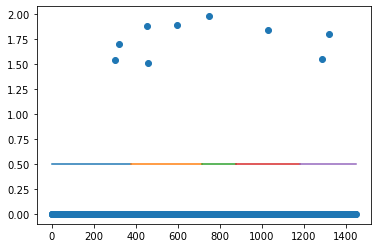

In [261]:
#plot -log10 p values
plt.scatter(range(len(genome_effect_sizes)), genome_effect_sizes)

#show ld blocks as lines
for i in range(len(ld_blocks)):
    x_values = [ld_blocks.loc[i, 'start'], ld_blocks.loc[i, 'end']]
    y_values = [0.5, 0.5]
    plt.plot(x_values, y_values)

plt.show()

In [262]:
ld_blocks

    

,chromosome,start,end
0,1.0,2.0,379.0
1,1.0,379.0,717.0
2,1.0,717.0,876.0
3,1.0,876.0,1183.0
4,1.0,1183.0,1449.0


In [264]:
p_values_genome = []

for ld_block_index, ld_blocks_row in ld_blocks.iterrows():
    
    n_snps = int(ld_blocks_row["end"] - ld_blocks_row["start"])
    
    n_haplotypes = 100
    neighborhood_length = 5
    maf = [random.uniform(0.05, 0.50) for _ in range(n_snps+neighborhood_length)]
    
    
    causal_indices = list(np.nonzero(genome_effect_sizes)[0])
    causal_indices = list(filter(lambda x: ld_blocks_row["start"] <= x <= ld_blocks_row["end"], causal_indices))
    adjusted_causal_indices = [int(x - ld_blocks_row["start"]) for x in causal_indices]

    causal_variants = ["snp" + str(int(s)) for s in adjusted_causal_indices]
    odds_ratios = [genome_effect_sizes[i] for i in causal_indices]
    
    n_controls = 100
    n_cases = 100

    p_values = simulate_p_values(n_snps, n_haplotypes, neighborhood_length, maf, causal_variants, odds_ratios, n_controls, n_cases)
    
    p_values_genome.extend(p_values)
    print(ld_block_index)

/var/folders/7j/329_cmn56qz2jnvgvylvq3dm0000gn/T/ipykernel_1703/1138240172.py:44: RuntimeWarning: invalid value encountered in double_scalars
  a = np.float64((2*EVX2-EVX*EVX))/(EVX2-EVX*EVX)
/var/folders/7j/329_cmn56qz2jnvgvylvq3dm0000gn/T/ipykernel_1703/1138240172.py:45: RuntimeWarning: invalid value encountered in double_scalars
  b = np.float64((EVX2*EVX))/(EVX2-EVX*EVX)


number of nan z scores:  30
0
number of nan z scores:  124
1
number of nan z scores:  129
2
number of nan z scores:  1
3
number of nan z scores:  31
4


In [ ]:
# #===================
# #JUST ONE LD BLOCK
# #===================
# p_values_genome = []

# ld_blocks_row = ld_blocks.iloc[2,:]

# n_snps = int(ld_blocks_row["end"] - ld_blocks_row["start"])

# n_haplotypes = 100
# neighborhood_length = 5
# maf = [random.uniform(0.05, 0.50) for _ in range(n_snps+neighborhood_length)]


# causal_indices = list(np.nonzero(genome_effect_sizes)[0])
# causal_indices = list(filter(lambda x: ld_blocks_row["start"] <= x <= ld_blocks_row["end"], causal_indices))
# adjusted_causal_indices = [int(x - ld_blocks_row["start"]) for x in causal_indices]

# causal_variants = ["snp" + str(int(s)) for s in adjusted_causal_indices]
# odds_ratios = [genome_effect_sizes[i] for i in causal_indices]

# n_controls = 100
# n_cases = 100

# p_values = simulate_p_values(n_snps, n_haplotypes, neighborhood_length, maf, causal_variants, odds_ratios, n_controls, n_cases)

# p_values_genome.extend(p_values)
# print(ld_block_index)

In [265]:
# ld_blocks_row = ld_blocks.loc[0,]
# causal_indices = list(np.nonzero(genome_effect_sizes)[0])
# adjusted_causal_indices = [int(x - ld_blocks_row["start"]) for x in causal_indices]
# causal_variants = ["snp" + str(int(s)) for s in adjusted_causal_indices]

# #only 2 cvs for this ld block
# causal_variants = causal_variants[0:2]

# print('causal_variants: ', causal_variants)

causal_variants = []
for i in range(len(ld_blocks)):
    ld_blocks_row = ld_blocks.loc[i,]
    causal_indices = list(np.nonzero(genome_effect_sizes)[0])
    adjusted_causal_indices = [int(x - ld_blocks.loc[0, "start"]) for x in causal_indices]
    causal_variants_n = ["snp" + str(int(s)) for s in adjusted_causal_indices]
    causal_variants.extend(causal_variants_n)
#only 2 cvs for this ld block
causal_variants

print('causal_variants: ', causal_variants)

causal_variants:  ['snp298', 'snp316', 'snp453', 'snp455', 'snp595', 'snp748', 'snp1027', 'snp1286', 'snp1320', 'snp298', 'snp316', 'snp453', 'snp455', 'snp595', 'snp748', 'snp1027', 'snp1286', 'snp1320', 'snp298', 'snp316', 'snp453', 'snp455', 'snp595', 'snp748', 'snp1027', 'snp1286', 'snp1320', 'snp298', 'snp316', 'snp453', 'snp455', 'snp595', 'snp748', 'snp1027', 'snp1286', 'snp1320', 'snp298', 'snp316', 'snp453', 'snp455', 'snp595', 'snp748', 'snp1027', 'snp1286', 'snp1320']


/var/folders/7j/329_cmn56qz2jnvgvylvq3dm0000gn/T/ipykernel_1703/149225835.py:5: RuntimeWarning: divide by zero encountered in log10
  neg_log_p_values = -1*np.log10(p_values_genome)


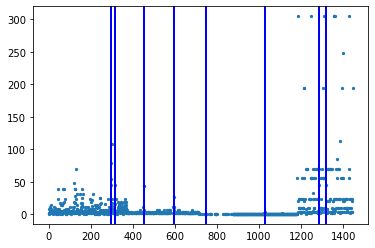

In [266]:
#plot p values
import matplotlib.pyplot as plt


neg_log_p_values = -1*np.log10(p_values_genome)


plt.scatter(range(len(neg_log_p_values)), neg_log_p_values, s = 5)
vert_line_pos = [int(e[3:]) for e in causal_variants] #[i for i, e in enumerate(['snp' + str(num1) for num1 in range(n_snps)]) if e in causal_variants]
for position in vert_line_pos:
    plt.axvline(x = position, color = 'b', label = 'axvline - full height')
# plt.show()
plt.savefig('simulated_p_values.png')


In [267]:

#pickle
import pickle

with open('inputs/simulated_p_values.pickle', 'wb') as handle:
    pickle.dump(p_values_genome, handle)
    
    
with open('inputs/simulated_effect_sizes.pickle', 'wb') as handle:
    pickle.dump(genome_effect_sizes, handle)
    
    
with open('inputs/simulated_annotations.pickle', 'wb') as handle:
    pickle.dump(annotations, handle)
    
    
with open('inputs/simulated_ld_blocks.pickle', 'wb') as handle:
    pickle.dump(ld_blocks, handle)
    
with open('inputs/simulated_causal_variants.pickle', 'wb') as handle:
    pickle.dump(causal_variants, handle)
    
with open('inputs/simulated_causal_genes.pickle', 'wb') as handle:
    pickle.dump(causal_genes, handle)

with open('inputs/simulated_causal_genes_to_snps.pickle', 'wb') as handle:
    pickle.dump(num_causal_snps, handle)
    
    
with open('inputs/simulated_networks.pickle', 'wb') as handle:
    pickle.dump(networks, handle)